<a href="https://colab.research.google.com/github/Subhash0606/Image-Captioner-using-Transformer/blob/main/Image%20Captioner%20Fine%20tune%20-%20Scratch/Image_Caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dependencies


In [ ]:
## Checking for GPU Access
!nvidia-smi

Mon Jan 16 13:06:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Preparing the Dataets

For this notebook, the transformer is trained on the MS-COCO Dataset

For More information on the dataset, visit the website:
https://cocodataset.org/#home

The dataset is also provided by tensorflow for experimentation:
Visit: https://www.tensorflow.org/datasets/catalog/coco_captions

In [ ]:
## MS-COCO Dataset
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510573713/13510573713 [==============================] - 219s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))

82783


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a person holding a bird in their hands <end>


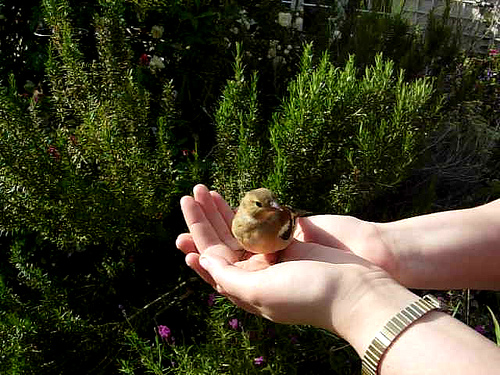

In [ ]:
## Sanity check
print(train_captions[11])
Image.open(img_name_vector[11])

Currently, `train_captions` is an array of captions corresponding with each image in `image_name_vector` which is an array o fimage paths

The captions in the `train_captions` array are tokenized using the TensorFLow TextVectorizer with tunable hyperparameters.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

At the End, while making the predictions, we also have to detokenize the tokens into word sequences for which two layers below are initialized to create mappings for words to indices and indices to words

`index_to_word` is used to detokenize the tokens while making predictions

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

As of now, the images are in the `image_name_vector` array as image paths. The model requires imagees to be fed as matrices

For this implementation, as the pretrained vision transformer model is used, the vision transformer requires images to be in the dimensions `(batch_size, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)`

For the Vision transformer used:

`IMAGE_SIZE` is 224

In [ ]:
## FUnction to load the images into the required format
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    return img

In [ ]:
image_ds = tf.data.Dataset.from_tensor_slices(img_name_vector)
image_ds = image_ds.map(
  load_image)

In [ ]:
## Sanity. check on the dataset

In [ ]:
## Normalizing the images in the dataset to be suitable for the neural network
def rescale(img):
  return img/255.

image_ds = image_ds.map(rescale)

## Initializing the pretrained Vision Transformer

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from vit_keras import vit

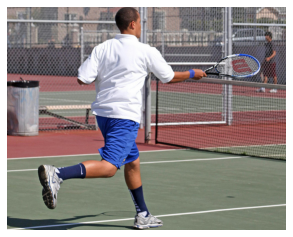

In [ ]:
## Image size for the Vision Transformer
IMAGE_SIZE = 224


import matplotlib.pyplot as plt
try_img = plt.imread(img_name_vector[0])
try_img = try_img/255.
plt.figure(figsize = (5, 5))
plt.imshow(try_img)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([try_img]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

For this implementaiton, the Vision transformer vit_b32 is used.

More details on the tensorflow hub website:

https://tfhub.dev/sayakpaul/collections/vision_transformer/1

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        )

353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Instead of classification we need the vision transformer to output a tensor of shape `(batch_size, seq_len, d_model)`

So we use the second to last layer on the vision transformer as the final layer giving the output shape: `shape=(None, 50, 768)`

In [ ]:
new_input = vit_model.input
hidden_layer = vit_model.layers[-2].output
## The New Vision Transformer Model with the required output shapes
vision_transformer_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
## For experimentation, freeze the layers of the pretrained Vision transformer
for layer in vision_transformer_model.layers:
  layer.trainable = False

In [ ]:
## Checking the model summary
vision_transformer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))        

### Positional Encodings for the captions

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

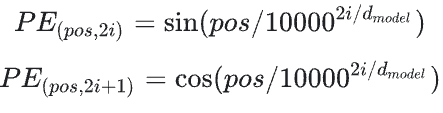

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking the sequences

The sequences are masked to seperate real tokens from paddings, the following create the masks for the tokens

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled Dot Product Attention

Here Q, K, and V are tensors, which are the results of the matrix multiplication between trained weights Wq, Wk, and Wv. As these three matrices of weights are learned during training, the query, key, and value vectors end up being different despite of the identical input. This is why Multi-Head Attention discussed later makes sense.


In the expression for calculation of the dot product attention, Q and K are tensors. Closer Query and Key Vectors will have higher dot products. These dot products are scaled with dk which is the scaling factor for the operation referring to the dimensions of the Key tensor. Applying the softmax function will normalize the dot product to scores between 0 and 1. Finally, multiplying the softmax results with the value vectors will push the low-scoring Query and Key vectors close to zero.

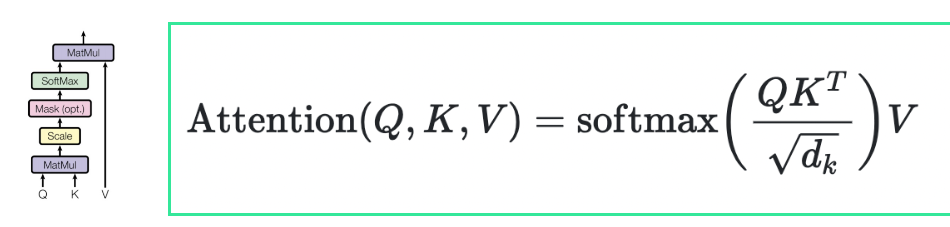

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

## Multi-Head Attention

In a Transformer Network, the Attention Module described earlier repeats its computations multiple times in parallel. Each of these computations is called an Attention Head. Each of these calculations is later combined to produce a final attention score.


As discussed earlier, for each Attention Head, Queries Q, Keys K, and Values V are calculated as results from learnable weight matrices Wq, Wk, and Wv. These weight matrices are different for each head, hence, for n number of heads n different weight matrices Wq, Wk and Wv are learned. Scaled dot product attention is carried out in each of the heads and finally, the results are concatenated together to form a rich representation.

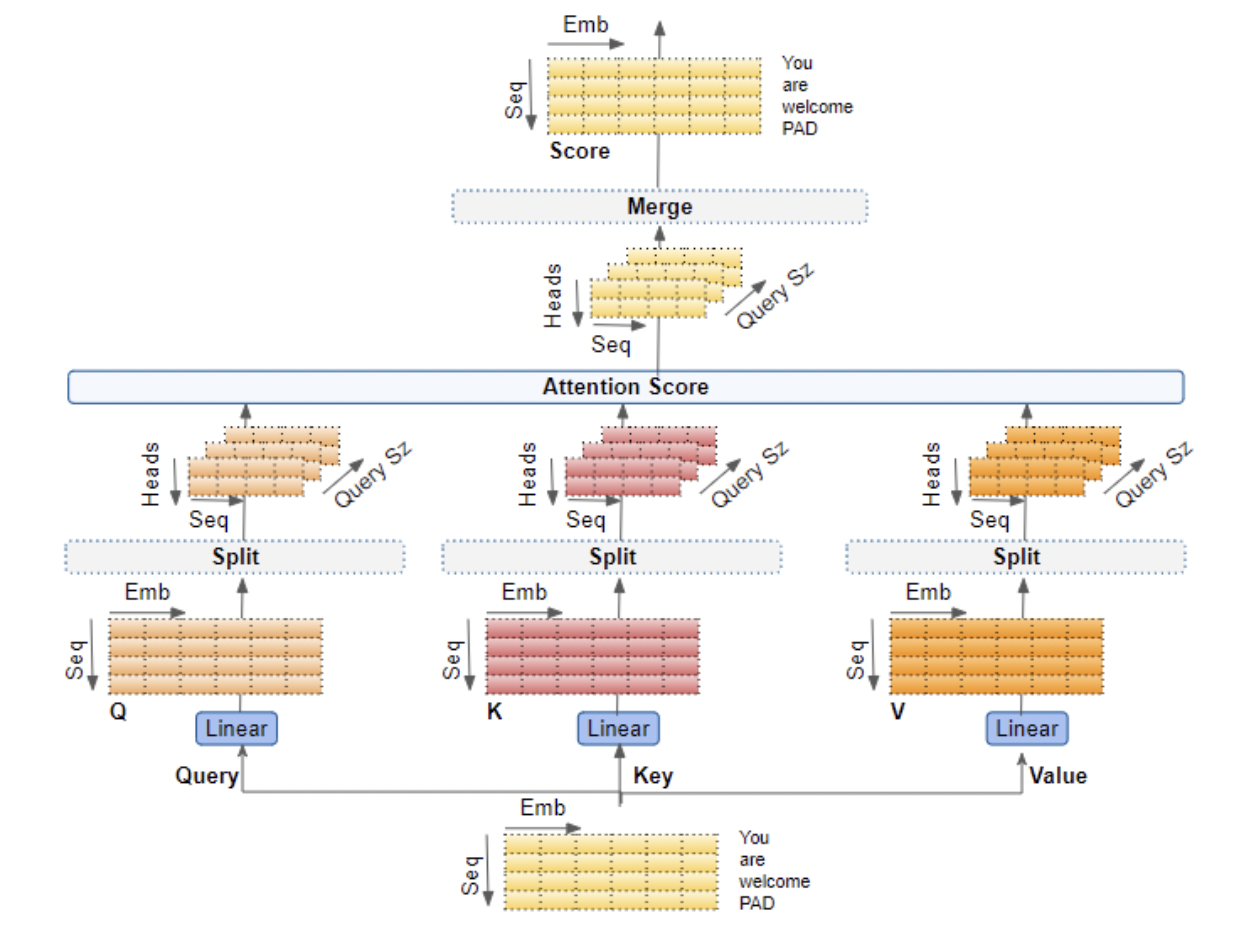

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    #print(f"Query shape: {q.shape}")
    #print(f"Key shape: {k.shape}")
    #print(f"value shape: {v.shape}")

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## The Encoder Layer

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, d_model, vision_transformer):
    super(Encoder, self).__init__()
    self.vit = vision_transformer
    self.units = d_model
    self.dense = tf.keras.layers.Dense(self.units, activation=tf.nn.gelu)

  def call(self, x, training, mask):
    ## x: (batch, image_size, image_size, 3)
    x = self.vit(x)
    x = self.dense(x)
    return x

In [ ]:
### Testing the Encoder
sample_encoder = Encoder(1024, vision_transformer_model)
sample_encoder_output = sample_encoder(resized_image, training=False, mask=None)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(1, 50, 1024)


## The Decoder

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
### Decoder Layer:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    #print(f"Decoder Layer input x shape: {x.shape}")

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    #print("attn2 shape: ", attn1.shape)
    #print(f"x shape: {x.shape}")
    out1 = self.layernorm1(attn1 + x)

    #print(f"Encoder outpur (Value and key) shape: {enc_output.shape}")
    #print(f"out1 (Query) shape: {out1.shape}")

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, None)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size, max_tokens,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.max_tokens =  max_tokens

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(max_tokens, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=1024, num_heads=8,
                         dff=2048, target_vocab_size=8000, max_tokens = 128)
temp_input = tf.random.uniform((1, 50), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([1, 50, 1024]), TensorShape([1, 8, 50, 50]))

## The Transformer

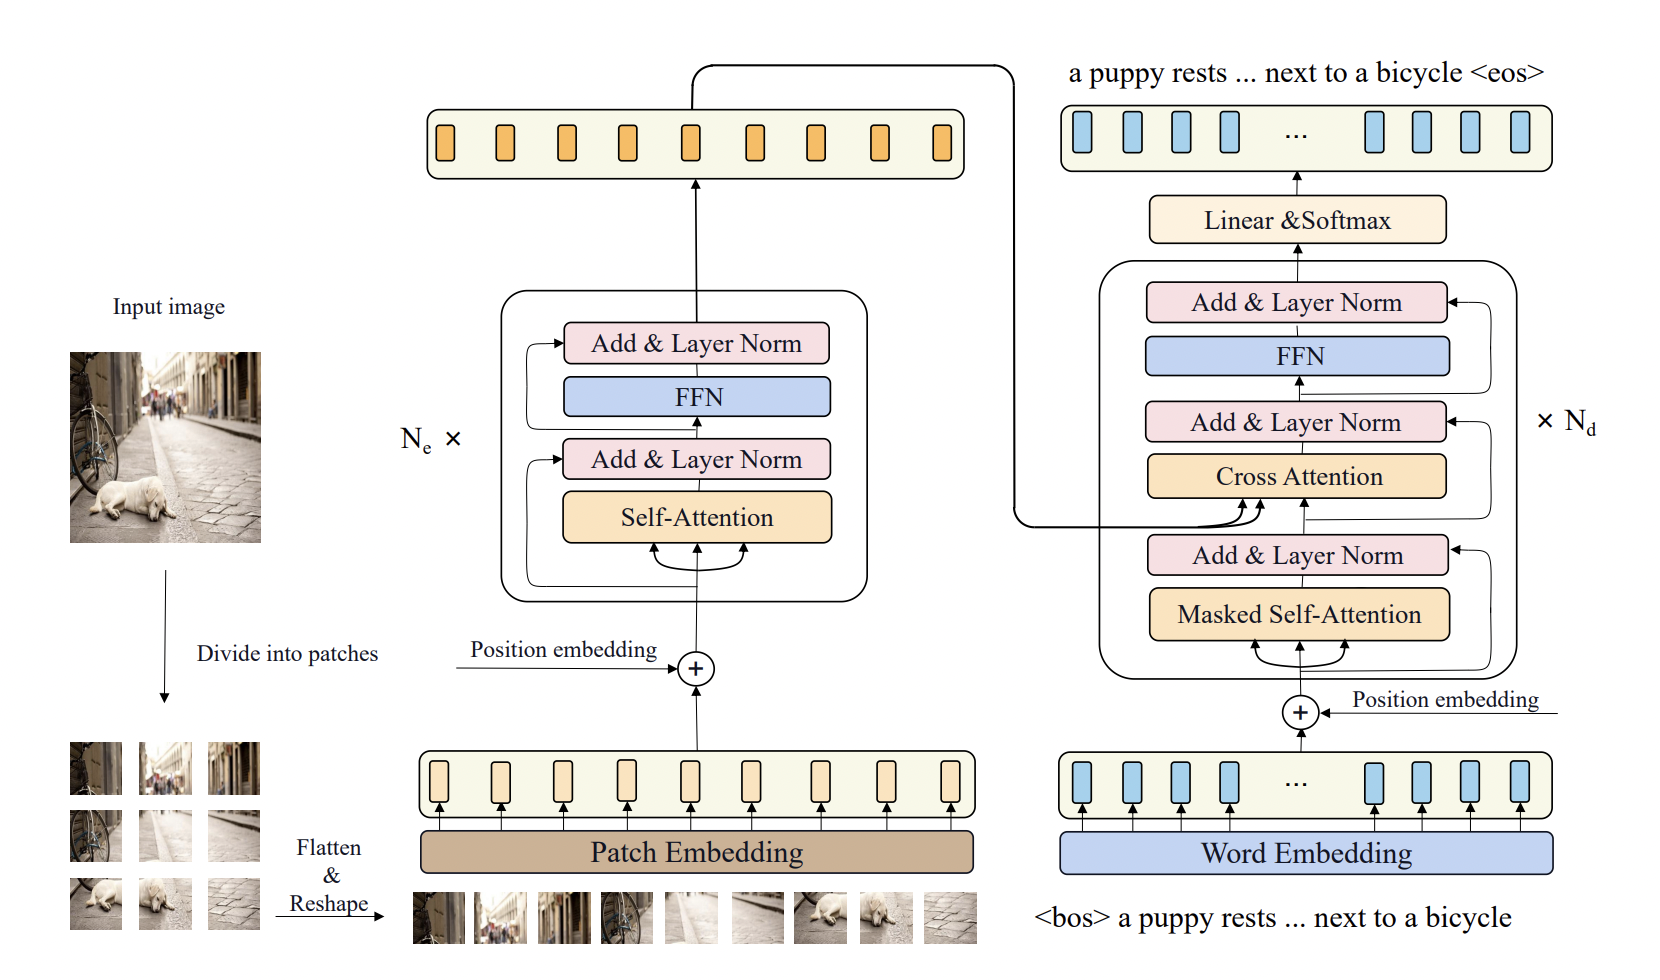

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff,
               target_vocab_size, vision_transformer, max_tokens, rate=0.1):
    super().__init__()
    self.vision_transformer = vision_transformer
    self.encoder = Encoder(d_model,
                           self.vision_transformer)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, max_tokens=max_tokens, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    #print("Transformer call function called")
    inp, tar = inputs
    #print(f"inp: {inp.shape}.     tar: {tar.shape}")
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    #print(f"Mask shapes: {padding_mask.shape}.    {look_ahead_mask.shape}")

    enc_output = self.encoder(inp, training, None)  # (batch_size, inp_seq_len, d_model)
    #print("Encoder Works")
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, vision_transformer = vision_transformer_model, max_tokens=128)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((1, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([resized_image, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([1, 36, 8000])

## Hyperparameters:

In [ ]:
## Hyperparameters for transformers
num_layers = 8
d_model = 256
dff = 512
num_heads = 4
dropout_rate = 0.1

## The Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

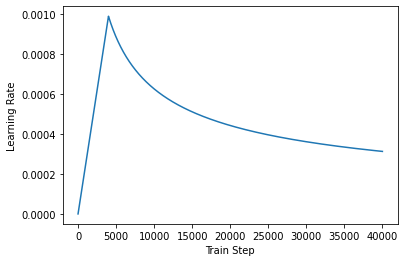

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training the Transformer

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=vocabulary_size,
    vision_transformer = vision_transformer_model,
    max_tokens = 128,
    rate=dropout_rate)

In [ ]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 1

The `@tf.function` is added as a decorator to speed up the training process by converting it to a graph executable:

More information on the official Tensorflow Documantation:

https://www.tensorflow.org/api_docs/python/tf/function

In [ ]:
@tf.function
def train_step(inp, tar):
  #print(inp.shape)
  #print(tar.shape)
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  #print(tar_inp)
  #print(tar_real)

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

## Preparing Data for training

In [ ]:
image_ds, cap_vector

(<MapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>,
 <MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>)

In [ ]:
train_batches = tf.data.Dataset.zip((image_ds, cap_vector))

In [ ]:
train_batches

<ZipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_batches = train_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for (batch, (inp, tar)) in enumerate(train_batches):
  print(batch)
  print(inp.shape)
  print(tar.shape)
  break

0
(128, 224, 224, 3)
(128, 50)


### Training the Transformer

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    #print(inp, tar)
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.5960 Accuracy 0.0007
Epoch 1 Batch 50 Loss 8.4327 Accuracy 0.0202
Epoch 1 Batch 100 Loss 8.1672 Accuracy 0.0796
Epoch 1 Batch 150 Loss 7.9053 Accuracy 0.1011
Epoch 1 Batch 200 Loss 7.6403 Accuracy 0.1121
Epoch 1 Batch 250 Loss 7.3670 Accuracy 0.1189
Epoch 1 Batch 300 Loss 7.0981 Accuracy 0.1288
Epoch 1 Batch 350 Loss 6.8565 Accuracy 0.1400
Epoch 1 Batch 400 Loss 6.6543 Accuracy 0.1496
Epoch 1 Batch 450 Loss 6.4786 Accuracy 0.1588
Epoch 1 Batch 500 Loss 6.3203 Accuracy 0.1683
Epoch 1 Batch 550 Loss 6.1736 Accuracy 0.1772
Epoch 1 Batch 600 Loss 6.0402 Accuracy 0.1851
Epoch 1 Batch 650 Loss 5.9146 Accuracy 0.1925
Epoch 1 Batch 700 Loss 5.7978 Accuracy 0.1993
Epoch 1 Batch 750 Loss 5.6887 Accuracy 0.2061
Epoch 1 Batch 800 Loss 5.5872 Accuracy 0.2129
Epoch 1 Batch 850 Loss 5.4917 Accuracy 0.2194
Epoch 1 Batch 900 Loss 5.4019 Accuracy 0.2256
Epoch 1 Batch 950 Loss 5.3184 Accuracy 0.2315
Epoch 1 Batch 1000 Loss 5.2392 Accuracy 0.2371
Epoch 1 Batch 1050 Loss 5.1642 Accur

## Function to caption the images

In [ ]:
def caption_image(image_path, transformer):
  """
  Uses the Transformer passed in the argument to caption the image
  """
  img = plt.imread(image_path)
  resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  ## Scaling the images
  resized_image = resized_image/255.
  ## Initializing the output arrays
  output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_array = output_array.write(0, [3])
  output = tf.transpose(output_array.stack())


  for i in tf.range(50):
    output = tf.transpose(output_array.stack())
    predictions, _ = transformer([resized_image, output], training=False)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output_array = output_array.write(i+1, predicted_id[0])
    if predicted_id == [4]:
      break

  output = tf.transpose(output_array.stack())
  print(index_to_word(output))
  plt.figure(figsize =  (5,  5))
  plt.imshow(resized_image[0])
  plt.axis("off")

tf.Tensor(
[[b'<start>' b'a' b'red' b'and' b'white' b'double' b'decker' b'bus' b'is'
  b'parked' b'in' b'the' b'street.' b'<end>']], shape=(1, 14), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'man' b'doing' b'a' b'skateboard' b'trick' b'on' b'a'
  b'skateboard.' b'<end>']], shape=(1, 11), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'man' b'jumping' b'over' b'a' b'skate' b'board' b'on'
  b'a' b'ramp.' b'<end>']], shape=(1, 12), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'car' b'sitting' b'on' b'the' b'ground' b'in' b'front'
  b'of' b'a' b'building.' b'<end>']], shape=(1, 13), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'man' b'in' b'a' b'white' b'shirt' b'holding' b'a'
  b'bat' b'and' b'a' b'ball' b'<end>']], shape=(1, 14), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'man' b'is' b'sitting' b'on' b'a' b'bed' b'with' b'a'
  b'laptop' b'on' b'the' b'bed.' b'<end>']], shape=(1, 15), dtype=string)
tf.Tensor(
[[b'<start>' b'a' b'dog' b'is' b'laying' b'on' b'the' b'floor' b'with'
  b'a' b'pie

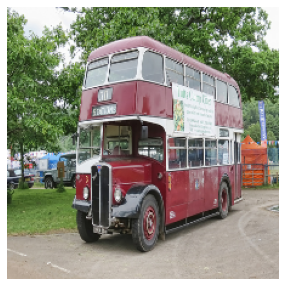

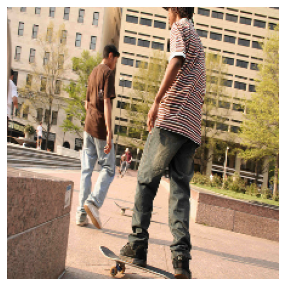

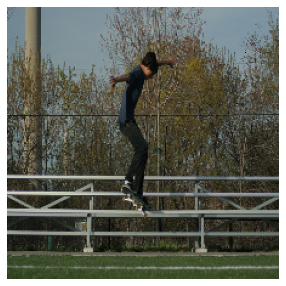

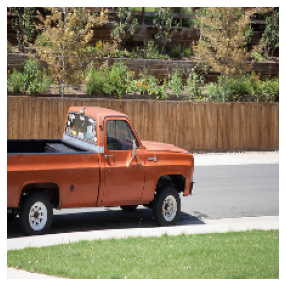

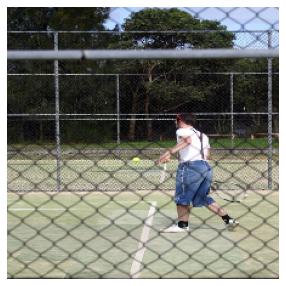

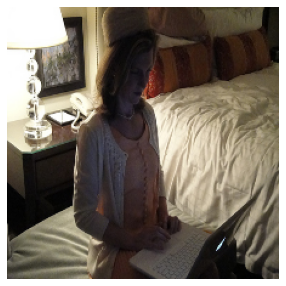

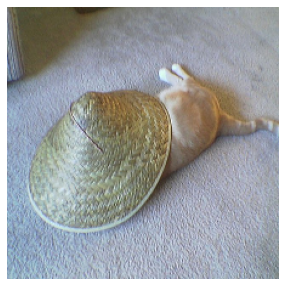

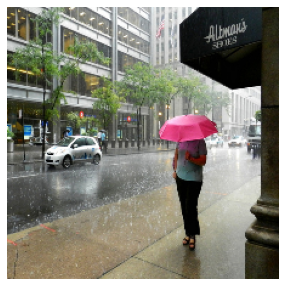

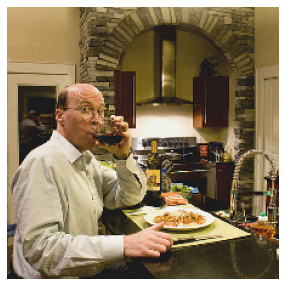

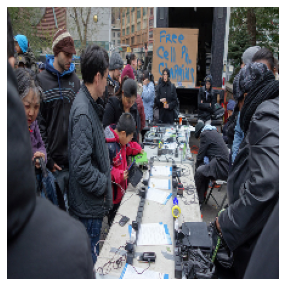

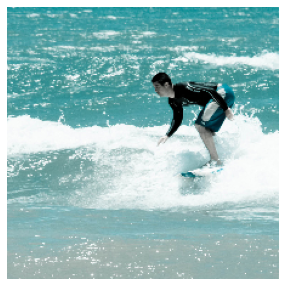

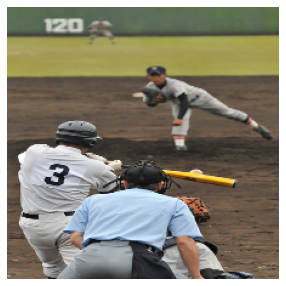

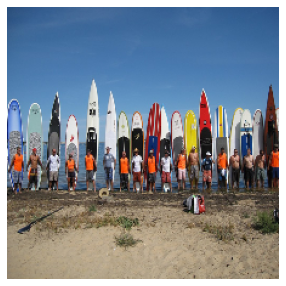

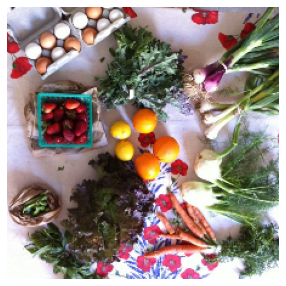

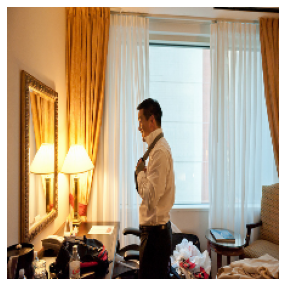

In [ ]:
import random
for i in range(15):
  a = random.randint(0, 20000)
  caption_image(img_name_vector[a], transformer)

In [ ]:
transformer.save("caption_transformer")

In [ ]:
from google.colab import files
files.download('caption_transformer')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip /content/caption_transformer /content/

  adding: content/ (stored 0%)
